<a href="https://colab.research.google.com/github/rajattiwari010/DenseNet_Customized_Model_1/blob/MY-REPO's/Dense_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:

import tensorflow as tf
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report
import os

# Define the paths to your dataset directories
benign_dir = r'/content/drive/MyDrive/Dataset/Untitled folder/New His dataset/Benign'
malignant_dir = r'/content/drive/MyDrive/Dataset/Untitled folder/New His dataset/Melignant'

# Load and preprocess the data
image_size = (32, 32)

image_files = []
labels = []

# Load images and map subfolder names to class labels
class_mapping = {
    'tubula_adenoma': 0,
    'phyllodes_tumor': 1,
    'fibroadenoma': 2,
    'adenosis': 3,
    'papillary_carcinoma': 4,
    'mucinous_carcinoma': 5,
    'lobular_carcinoma': 6,
    'ductal_carcinoma': 7
}


In [11]:
for root_dir, _, filenames in os.walk(benign_dir):
    for filename in filenames:
        if filename.endswith('.png'):
            image_path = os.path.join(root_dir, filename)
            image_files.append(image_path)
            class_name = os.path.basename(root_dir)
            labels.append(class_mapping[class_name])

for root_dir, _, filenames in os.walk(malignant_dir):
    for filename in filenames:
        if filename.endswith('.png'):
            image_path = os.path.join(root_dir, filename)
            image_files.append(image_path)
            class_name = os.path.basename(root_dir)
            labels.append(class_mapping[class_name])



# Ensure that there are samples for both classes
if len(image_files) == 0:
    raise ValueError("No image files found in the specified directories.")

# Split the data into a training (70%) and testing (30%) set
X_train, X_test, y_train, y_test = train_test_split(image_files, labels, test_size=0.3, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, num_classes=8)
y_test = to_categorical(y_test, num_classes=8)



In [20]:
# Create TensorFlow datasets for training and testing with one-hot encoded labels
batch_size = 32

def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.keras.applications.densenet.preprocess_input(img)
    return img



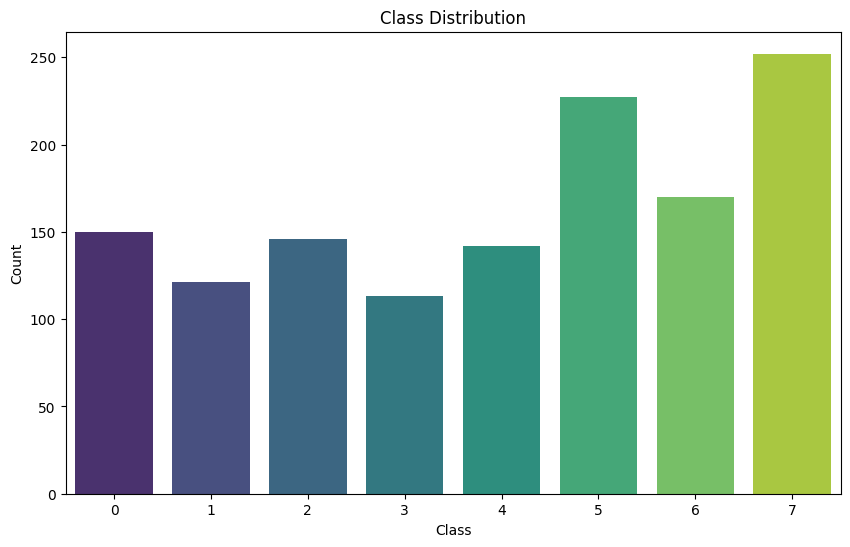

In [13]:

# visualising the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=labels, palette='viridis')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


In [23]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(lambda x, y: (preprocess_image(x), y))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.map(lambda x, y: (preprocess_image(x), y))
test_dataset = test_dataset.batch(batch_size)

# Define the model architecture for multi-class classification
num_classes = 8  # 8 classes now
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.7)(x)
predictions = Dense(num_classes, activation='softmax')(x)  # Softmax activation for multi-class
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
epochs = 10
model.fit(train_dataset, validation_data=test_dataset, epochs=epochs)


74836368/74836368 [==============================] - 0s 0us/step
Epoch 1/10
29/29 [==============================] - 262s 3s/step - loss: 2.3752 - accuracy: 0.1764 - val_loss: 1.9929 - val_accuracy: 0.2645
Epoch 2/10
29/29 [==============================] - 16s 291ms/step - loss: 2.0112 - accuracy: 0.2489 - val_loss: 1.8380 - val_accuracy: 0.3275
Epoch 3/10
29/29 [==============================] - 13s 256ms/step - loss: 1.8948 - accuracy: 0.2879 - val_loss: 1.7679 - val_accuracy: 0.3703
Epoch 4/10
29/29 [==============================] - 14s 292ms/step - loss: 1.7610 - accuracy: 0.3615 - val_loss: 1.7225 - val_accuracy: 0.4055
Epoch 5/10
29/29 [==============================] - 14s 298ms/step - loss: 1.7257 - accuracy: 0.3561 - val_loss: 1.6566 - val_accuracy: 0.4383
Epoch 6/10
29/29 [==============================] - 13s 263ms/step - loss: 1.6421 - accuracy: 0.4058 - val_loss: 1.6410 - val_accuracy: 0.4383
Epoch 7/10
29/29 [==============================] - 15s 289ms/step - loss: 1.60

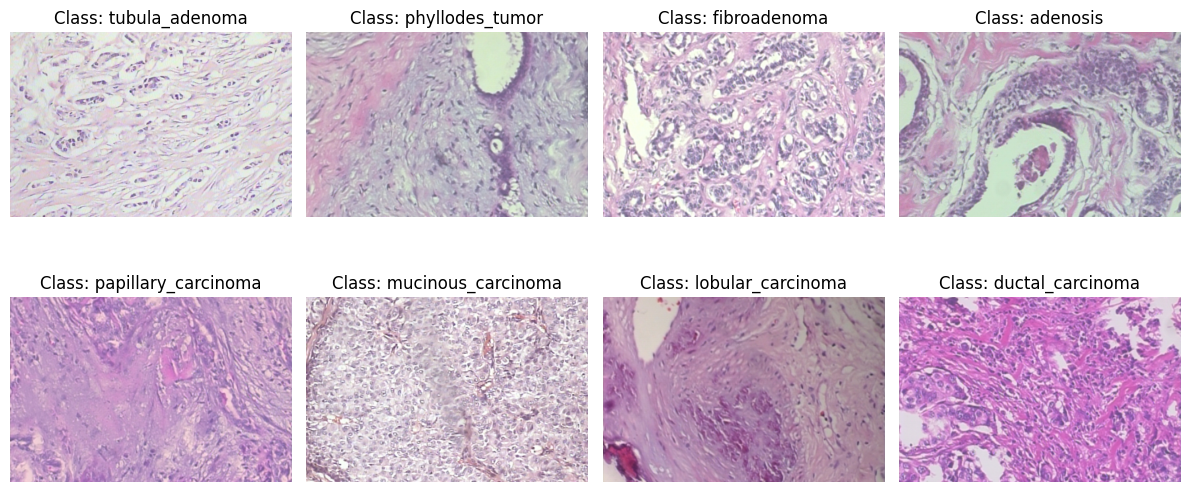

In [28]:
import matplotlib.pyplot as plt

# Create a list of class indices
class_indices = list(range(num_classes))

# Create a dictionary to store the first image path for each class
class_first_images = {i: None for i in class_indices}

# Find the first image path for each class in the training set
for img_path, label in zip(X_train, y_train):
    class_index = tf.argmax(label).numpy()
    if class_first_images[class_index] is None:
        class_first_images[class_index] = img_path

# Create subplots with appropriate spacing
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # Adjust figsize as needed

# Display the first image for each class
for i, ax in zip(class_indices, axes.flat):
    img_path = class_first_images[i]
    img = plt.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"Class: {class_names[i]}")
    ax.axis('off')

plt.tight_layout()  # Adjust subplot spacing
plt.show()


In [25]:
# model layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 16, 16, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1/conv[0][0]']      

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.47441 to fit



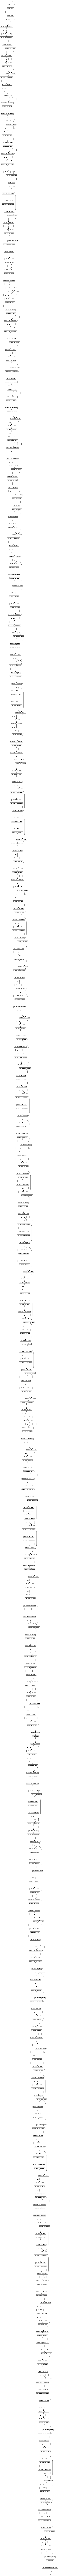

In [26]:
#flowchart of model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [27]:
#testing
loss, acc = model.evaluate(test_dataset)
print("loss: ",loss)
print("accuracy: ",acc)

13/13 [==============================] - 6s 460ms/step - loss: 1.5602 - accuracy: 0.4610
loss:  1.5601540803909302
accuracy:  0.4609571695327759


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Preprocess the test dataset
X_test_preprocessed = [preprocess_image(image_path) for image_path in X_test]

# Convert the list of preprocessed images to a numpy array
X_test_preprocessed = np.array(X_test_preprocessed)

# Predict probabilities
y_pred_prob = model.predict(X_test_preprocessed)

# Convert probabilities to binary predictions using a threshold of 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))



13/13 [==============================] - 4s 142ms/step
Accuracy on Test Data: 0.22%
              precision    recall  f1-score   support

           0       0.60      0.07      0.12        46
           1       1.00      0.06      0.11        51
           2       0.40      0.05      0.09        39
           3       0.67      0.22      0.33        27
           4       0.33      0.07      0.12        40
           5       0.56      0.23      0.33        60
           6       1.00      0.12      0.21        51
           7       0.89      0.61      0.73        83

   micro avg       0.74      0.22      0.34       397
   macro avg       0.68      0.18      0.26       397
weighted avg       0.72      0.22      0.30       397
 samples avg       0.22      0.22      0.22       397



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model_save_path = '/content/drive/MyDrive/Dataset/model Folder 1'

# Save the model to the specified path
model.save(model_save_path)

print("Model saved successfully to:", model_save_path)


Model saved successfully to: /content/drive/MyDrive/Dataset/model Folder 1
